In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import filtfilt
import pandas as pd
import os

In [94]:
def process_tailangle_signal(df, window_size=15, min_dist=10, prominence=0.05):
    """ Processes the tail angle signal
    Args: 
        df from DLC body part coordinate positions, processed through tail position script (Tail_Position_Series_Construction.ipynb)
        window_size (int): # frames by which to smooth tail angle signal to detect peaks
        min_distance (int): min distance between peaks (samples) in frames
        prominence (float): min prominence of peaks to be considered valid in degrees
    Returns: df with computed time, smoothed signal, peaks, and minima identified as "1" in their respective columns
    """
    # make a copy of df
    df = df.copy()

    # add time column (s)
    df['time'] = df['index'] / 24 # hard coded fps

    # interpolate missing angles linearly to address NAs
    df['theta_flex_deg'] = df['theta_flex_deg'].interpolate(method='linear', limit_direction='forward', axis=0)

    # convert theta to radians for computation
    theta_rad = np.deg2rad(df['theta_flex_deg'])

    # apply moving avg filter for peak detection
    df['smooth_signal'] = filtfilt(np.ones(window_size)/window_size, [1], theta_rad)

    # detect peaks using scipy function
    peaks, _ = find_peaks(df['smooth_signal'], distance=min_dist, prominence=prominence)

    # detect minima using scipy function 
    minima, _ = find_peaks(-df['smooth_signal'], distance=min_dist, prominence=prominence)

    # add peaks and minima cols
    df['peaks'], df['minima'] = 0, 0
    df.loc[peaks, 'peaks'], df.loc[minima, 'minima'] = 1, 1

    return df
    

# Extract Cycles

In [ ]:
def extract_tailangle_cycles(df, minimum_signal=15):
    """ creates a df where each row is a cycle in the tail angle signal 
    Args: 
        df from DLC body part coordinate positions, processed through tail position script (Tail_Position_Series_Construction.ipynb)
        minimum_signal (int): # minimum frames required for processing (corresponds to window_size)
    Returns: df where each row represents one cycle with:
        'frequency_hz': frequency (1 / duration), 't_s': start time, 
        'amplitude_deg': peak-to-peak amplitude, head_amplitude_deg: amplitude of head wagging in deg
    """
    # check if the signal is long enough to apply the filter
    if df['theta_flex_deg'].notna().sum() < minimum_signal: 
        return pd.DataFrame(columns=['frequency_hz', 't_s', 'amplitude_deg', 'head_amplitude_deg', 
                                     'flex_amplitude_BL', 'head_amplitude_BL', 'BL_pixels', 'segment_id'])  # return empty df
    
    df = process_tailangle_signal(df)

    all_cycles = []
    segments = df[df['segment'] != -1].groupby('segment')

    # skip if segment is too short to process
    for segment_id, segment_df in segments:
        if segment_df['theta_flex_deg'].notna().sum() < minimum_signal:
            continue

        # identify peak and minima indices
        peak_indices = segment_df[segment_df['peaks'] == 1].index.to_numpy()
        minima_indices = segment_df[segment_df['minima'] == 1].index.to_numpy()

        # ensure minimum num of peaks exist
        if len(peak_indices) < 2: continue

        cycles = []
        
        # define cycles from consecutive peaks
        for i in range(len(peak_indices) - 1):
            start_peak, next_peak = peak_indices[i], peak_indices[i + 1]

            # extract t
            t_s = segment_df.at[start_peak, 'time']
            cycle_duration = segment_df.at[next_peak, 'time'] - t_s
            frequency_hz = 1 / cycle_duration if cycle_duration > 0 else float('nan')

            # find minima
            cycle_minima = minima_indices[(minima_indices > start_peak) & (minima_indices < next_peak)]
            min_amp = segment_df.loc[cycle_minima, 'theta_flex_deg'].min() if len(cycle_minima) > 0 else segment_df.at[start_peak, 'theta_flex_deg']

            # max and flexion amplitude (degrees)
            max_amp = segment_df.at[start_peak, 'theta_flex_deg']
            flex_amplitude_deg = (max_amp - min_amp)/2 

            # BL as the average BL_pixels over a cycle
            cycle_BL_pixels = segment_df.loc[start_peak:next_peak, 'BL_pixels']
            BL_pixels = cycle_BL_pixels.mean() if not cycle_BL_pixels.dropna().empty else float('nan')

            # flexion amplitude (BL)
            cycle_flex_BL = segment_df.loc[start_peak:next_peak, 'amp_flex_BL']
            flex_amplitude_BL = (cycle_flex_BL.max() - cycle_flex_BL.min()) / 2 if not cycle_flex_BL.dropna().empty else float('nan')

            # head amplitude (degrees)
            cycle_theta_head = segment_df.loc[start_peak:next_peak, 'theta_head_deg']
            head_amplitude_deg = (cycle_theta_head.max() - cycle_theta_head.min()) / 2 if not cycle_theta_head.dropna().empty else float('nan')

            # head amplitude (BL)
            cycle_head_BL = segment_df.loc[start_peak:next_peak, 'amp_head_BL']
            if cycle_head_BL.dropna().empty: head_amplitude_BL = float('nan')
            else: head_amplitude_BL = (cycle_head_BL.max() - cycle_head_BL.min()) / 2

            # store cycle information
            cycles.append({'frequency_hz': frequency_hz, 't_s': t_s, 'flex_amplitude_deg': flex_amplitude_deg, 
                           'head_amplitude_deg': head_amplitude_deg, 'flex_amplitude_BL': flex_amplitude_BL, 
                           'head_amplitude_BL': head_amplitude_BL, 'BL_pixels': BL_pixels, 'segment_id':segment_id})
            
        all_cycles.extend(cycles)

    return pd.DataFrame(all_cycles)


# Plot 

In [96]:
def plot_tailangle(df):
  """ Plots the original and smothed tail angle signal, marking peaks and minima
  Args: df from DLC body part coordinate positions, processed through tail position script (Tail_Position_Series_Construction.ipynb)
  Returns: plot of signal with peaks and minima marked
  """
  df = process_tailangle_signal(df)  # Ensure the df has processed data

  # Convert smoothed signal back to degrees for visualization
  smooth_signal_deg = np.rad2deg(df['smooth_signal'])

  # Extract peak and minima times
  peak_times = df.loc[df['peaks'] == 1, 'time']
  minima_times = df.loc[df['minima'] == 1, 'time']

  # Plot signals and detected points
  plt.figure(figsize=(10, 5))
  plt.plot(df['time'], df['theta_flex_deg'], label='Original Signal', alpha=0.5)
  plt.plot(df['time'], smooth_signal_deg, label='Smoothed Signal', linewidth=2)
  plt.scatter(peak_times, smooth_signal_deg[df['peaks'] == 1], color='r', label='Peaks', zorder=3)
  plt.scatter(minima_times, smooth_signal_deg[df['minima'] == 1], color='g', label='Minima', zorder=3)

  # Formatting
  plt.xlabel('Time (sec)')
  plt.ylabel('Amplitude (degrees)')
  plt.title(df['file_name'][1])
  plt.legend()
  plt.grid(True)
  plt.show()


def plot_headangle(df):
    """ Plots the original and smoothed head angle signal, marking peaks and minima
    Args: 
        df from DLC body part coordinate positions, processed through tail position script
    Returns: 
        plot of signal with peaks and minima marked
    """
    # You can process the head angle similarly to the tail angle if needed
    # For simplicity, we will just plot the raw 'theta_head_deg' here

    df = process_tailangle_signal(df)  # Ensure the df has processed data
    peak_times = df.loc[df['peaks'] == 1, 'time']
    minima_times = df.loc[df['minima'] == 1, 'time']

    head_angle_deg = df['theta_head_deg']

    # Plot signals and detected points
    plt.figure(figsize=(10, 5))
    plt.plot(df['time'], head_angle_deg, label='Head Angle (Original)', alpha=0.7, color='orange')
    
    # Plotting peaks and minima if detected in the head angle signal
    plt.scatter(peak_times, head_angle_deg[df['peaks'] == 1], color='r', label='Peaks', zorder=3)
    plt.scatter(minima_times, head_angle_deg[df['minima'] == 1], color='g', label='Minima', zorder=3)

    # Formatting
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude (degrees)')
    plt.title(df['file_name'][1] if 'file_name' in df else 'Head Angle Signal')
    plt.legend()
    plt.grid(True)
    plt.show()

# Collate and Export all Data

In [ ]:
# paths for example data
file_path = "I:/documents/DLCPaper/revisions/data/kinematic/example_data/07202023PANB0605DLC_cleanedangles.csv"
export_path = "I:/documents/DLCPaper/revisions/data/kinematic/example_data/07202023PANB0605DLC_cycles.csv"

# convert and export
ex_df = pd.read_csv(file_path)
#kinematics_df = process_tailangle_signal(ex_df)
cycles_df = extract_tailangle_cycles(ex_df)
#kinematics_df.to_csv(export_path, index=False)
cycles_df.to_csv(export_path, index=False)

KeyError: 'segment'

transf_07202023PANB0202DLC.csv


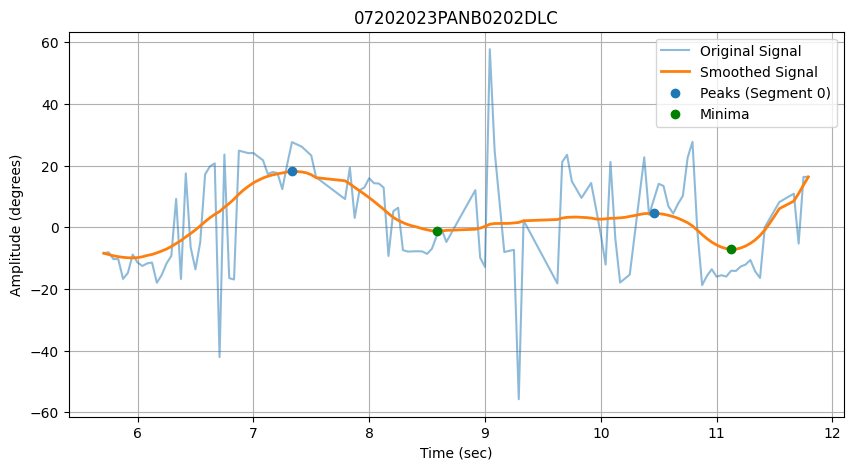

transf_07202023PANB0204DLC.csv


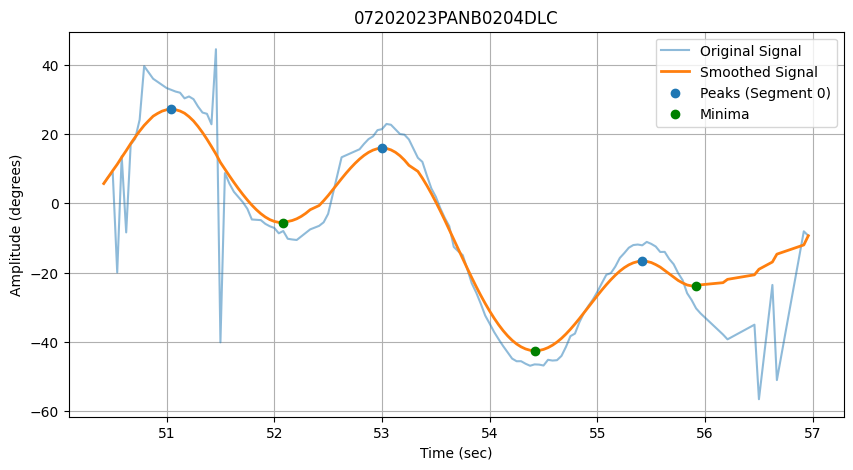

transf_07202023PANB0604DLC.csv


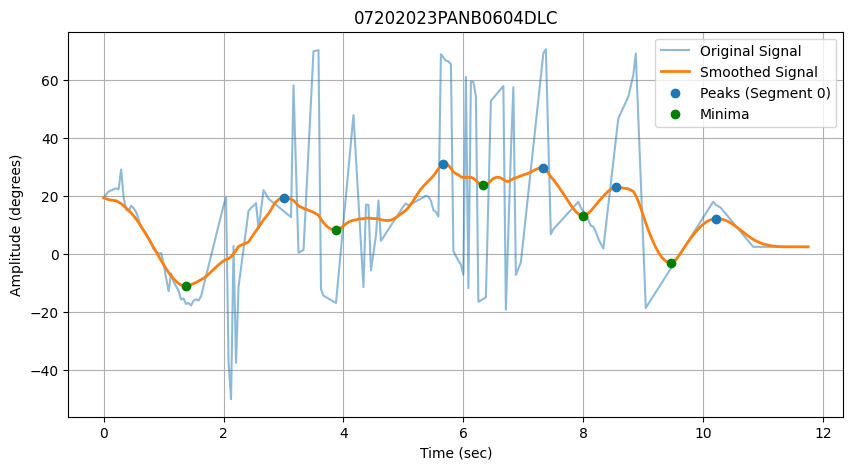

transf_07202023PANB0503DLC.csv


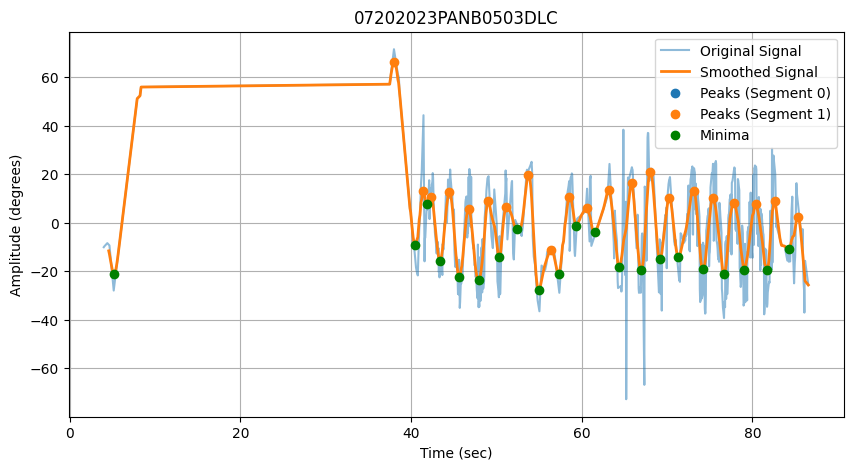

transf_07202023PANB0701DLC.csv


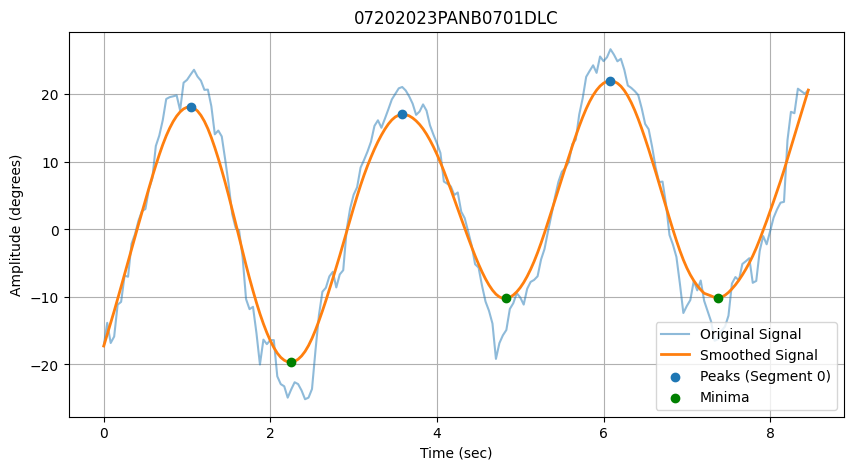

transf_07202023PANB0305DLC.csv


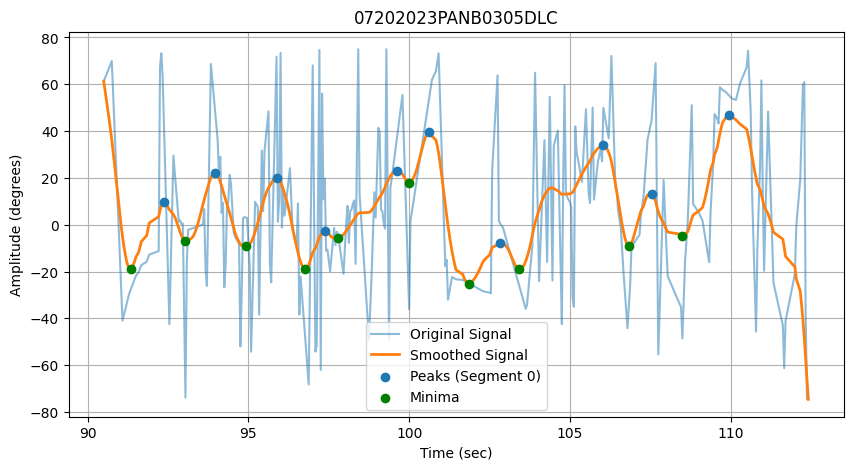

transf_07202023PANB0605DLC.csv


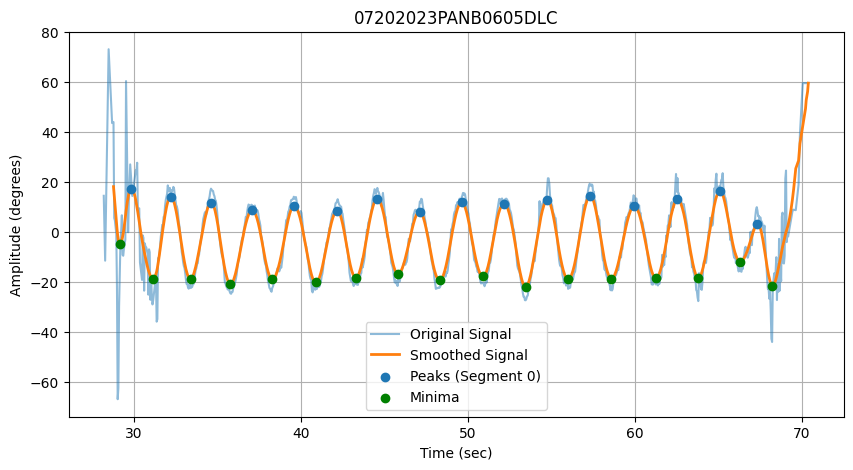

transf_07202023PANB0502DLC.csv


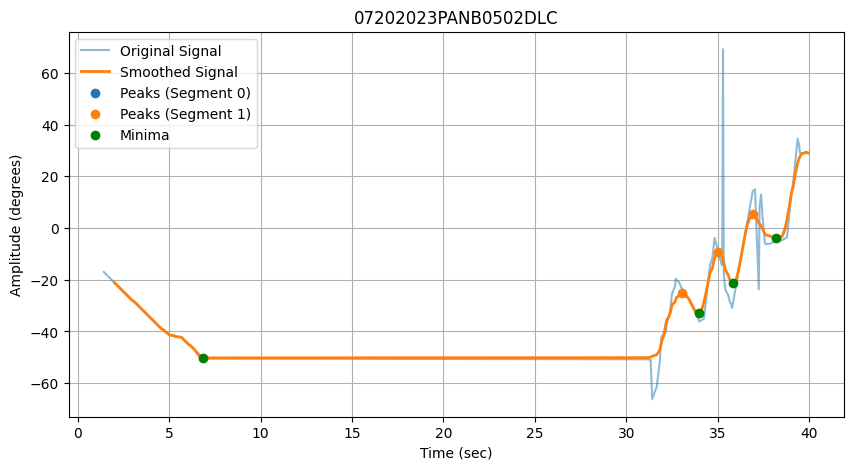

transf_07202023PANB0702DLC.csv


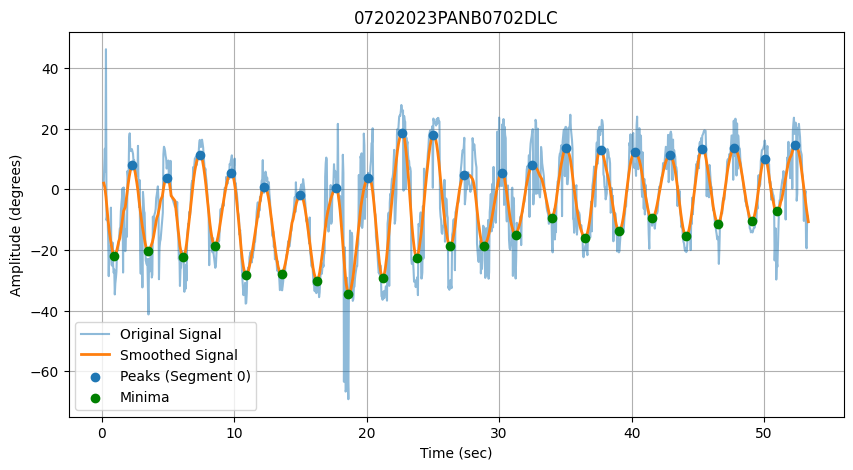

transf_07202023PANB0504DLC.csv


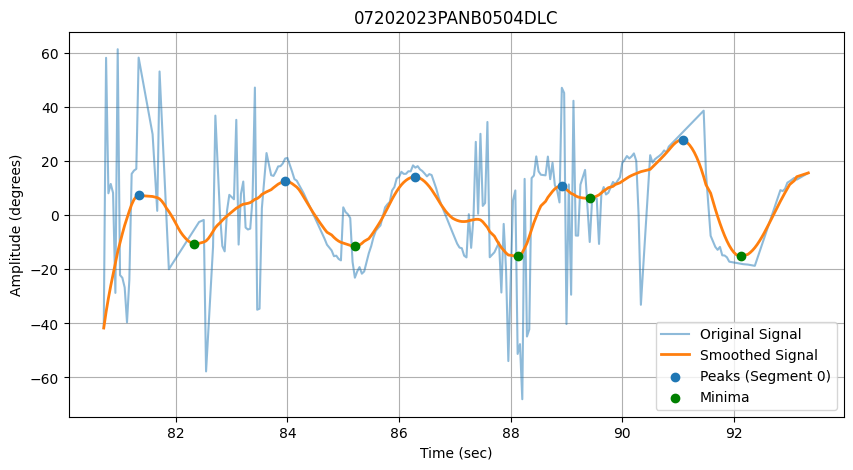

transf_07202023PANB0203DLC.csv


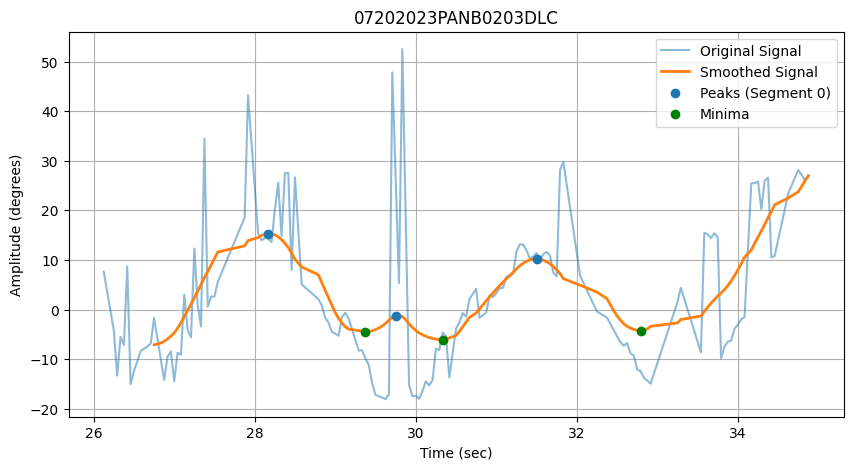

transf_07202023PANB0804DLC.csv


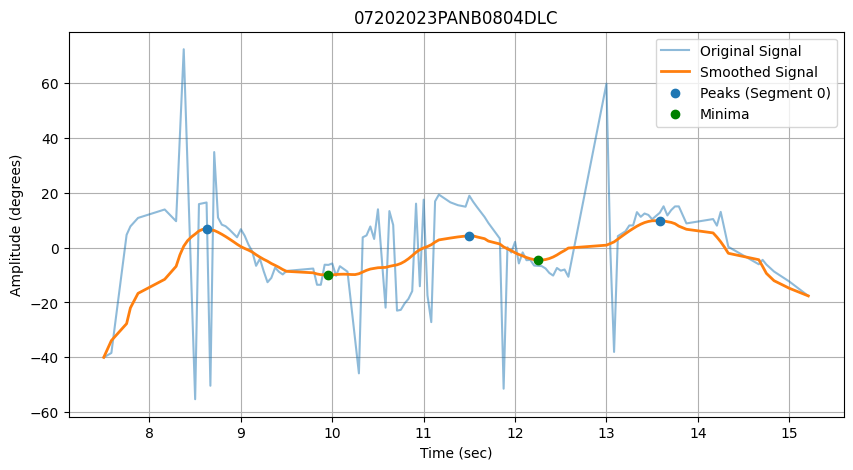

transf_07202023PANB0703DLC.csv


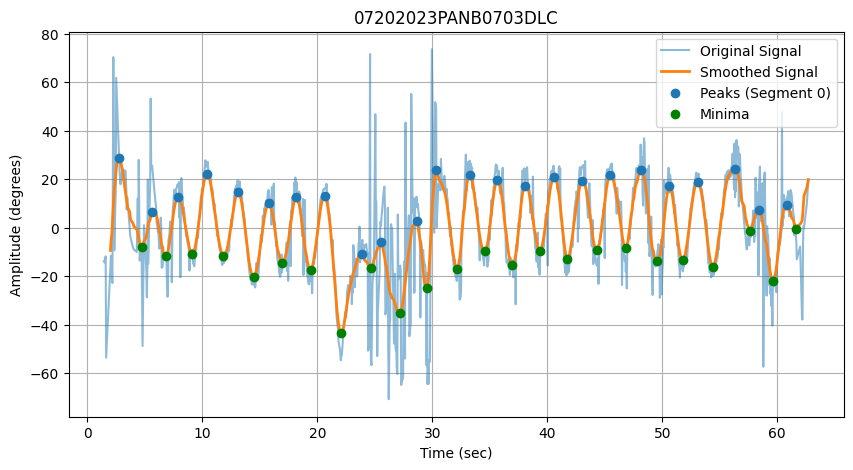

transf_07252023PANB0202DLC.csv


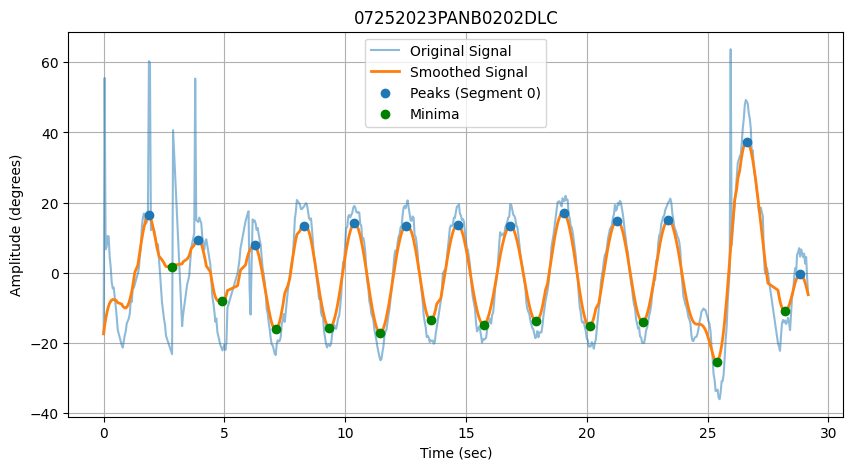

transf_07252023PANB0201DLC.csv


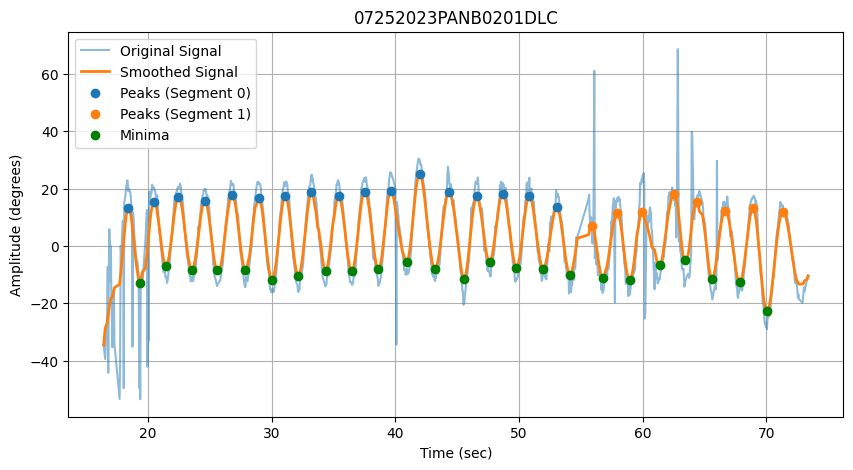

transf_07202023PANB0805DLC.csv


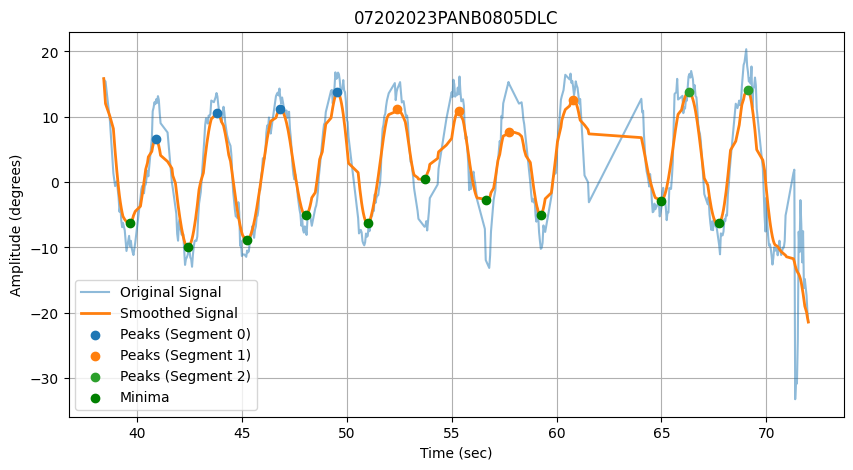

transf_07202023PANB0704DLC.csv


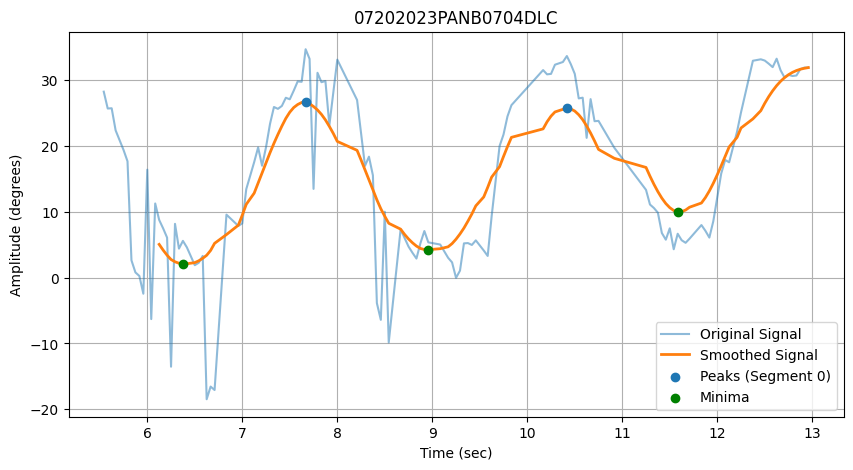

transf_07202023PANB0706DLC.csv


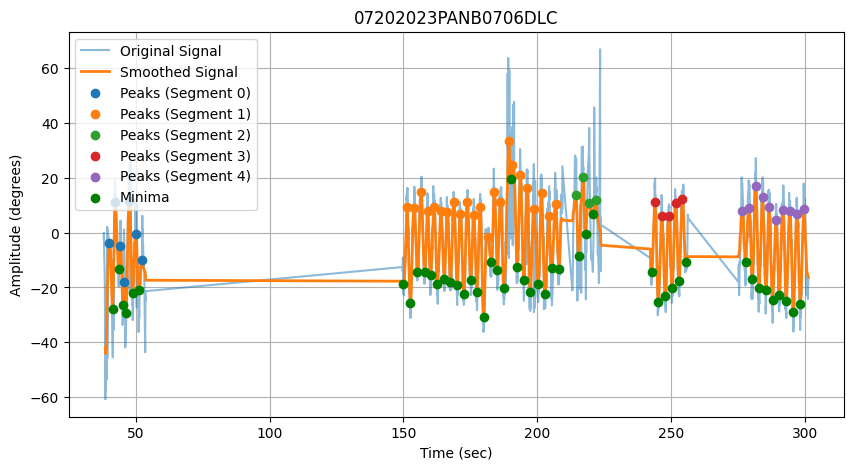

transf_07202023PANB0801DLC.csv


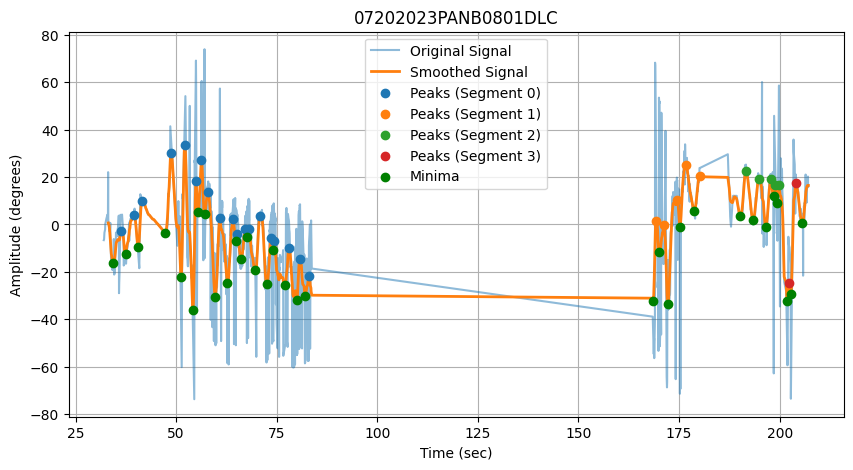

transf_07252023PANB0101DLC.csv


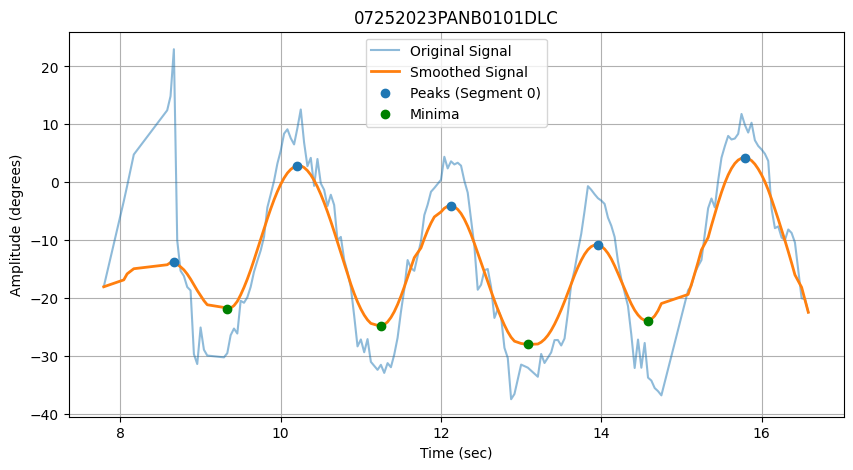

transf_07252023PANB0203DLC.csv


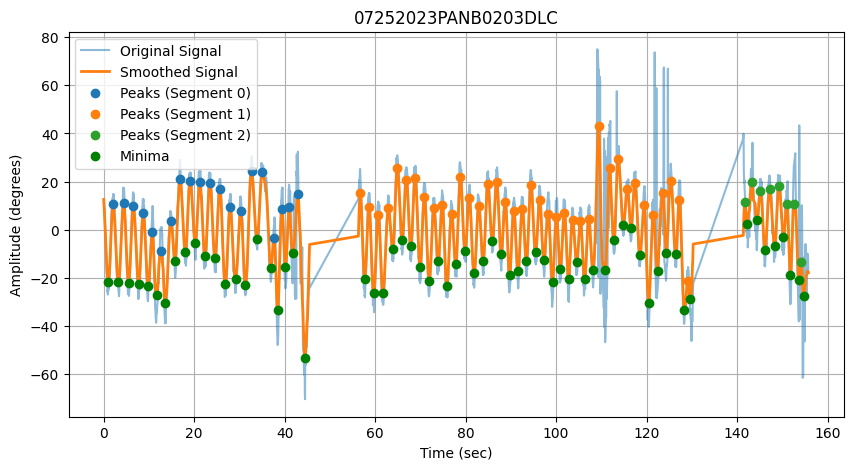

transf_07252023PANB0303DLC.csv


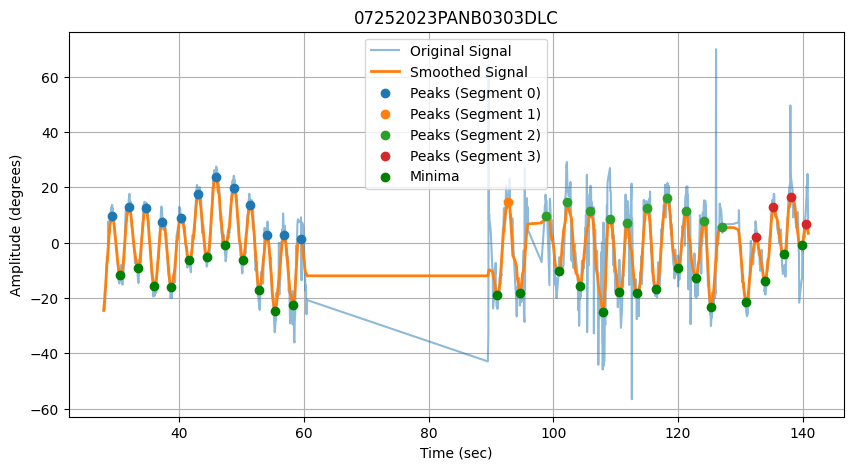

transf_07252023PANB0302DLC.csv


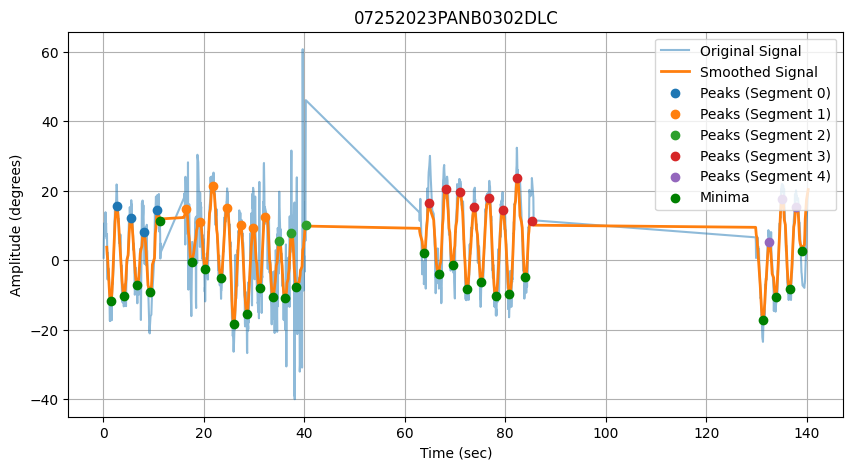

transf_07252023PANB0304DLC.csv


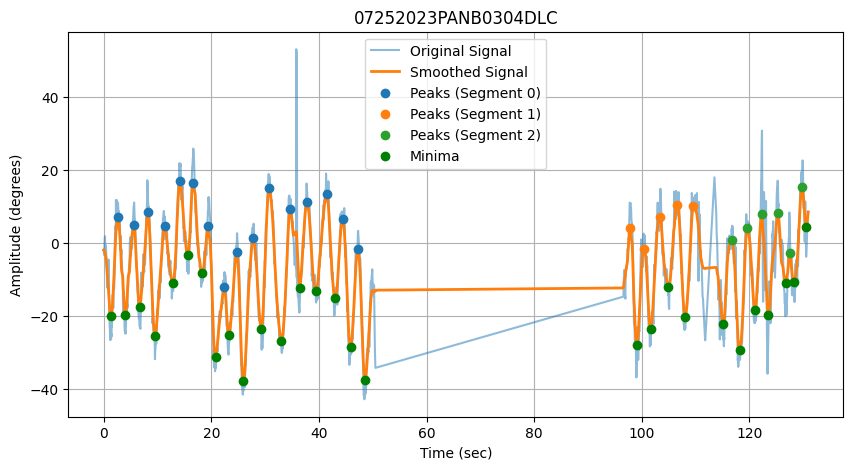

transf_07252023PANB0301DLC.csv


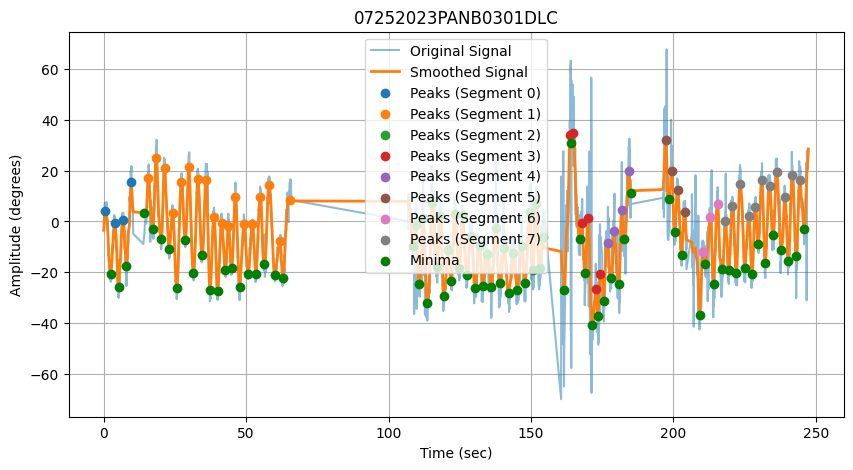

transf_07252023PANB0204DLC.csv


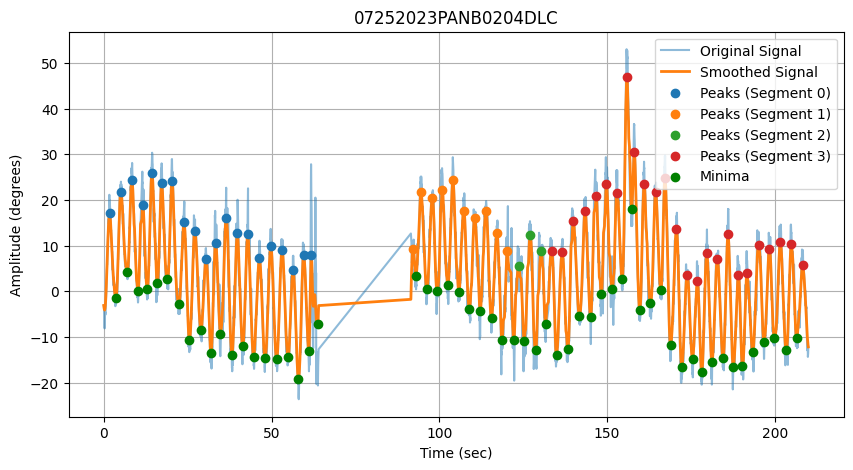

transf_07252023PANB0501DLC.csv


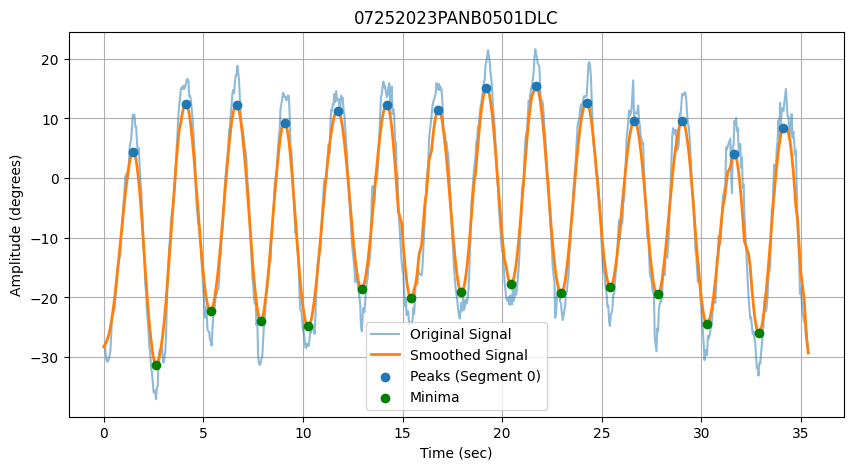

transf_07252023PANB0603DLC.csv


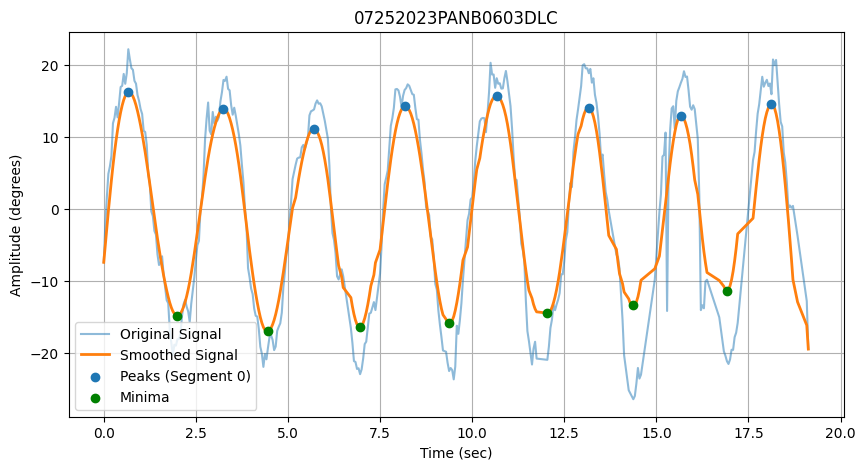

transf_07252023PANB0205DLC.csv


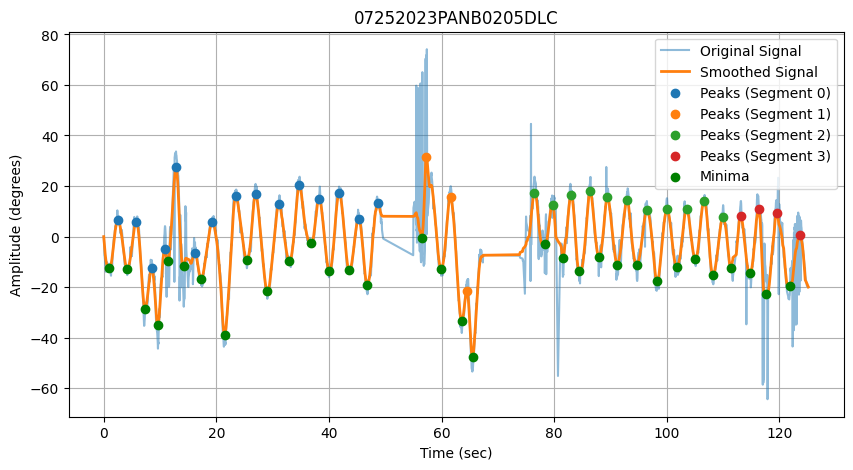

transf_07252023PANB0604DLC.csv


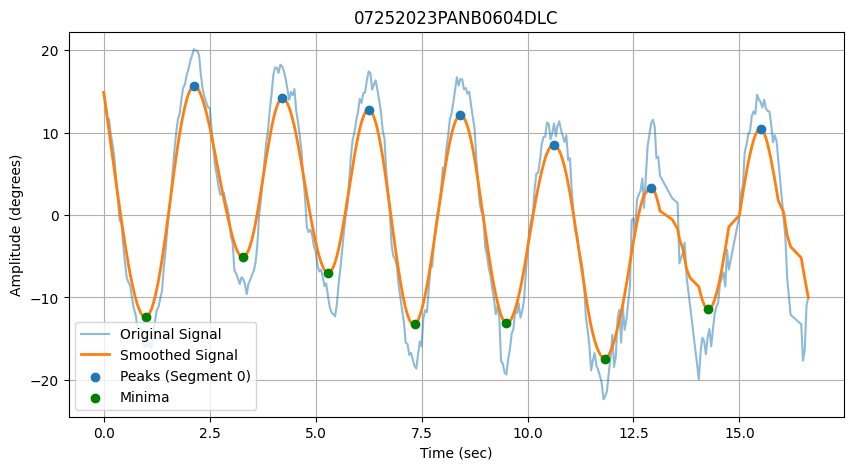

transf_07252023PANB0601DLC.csv


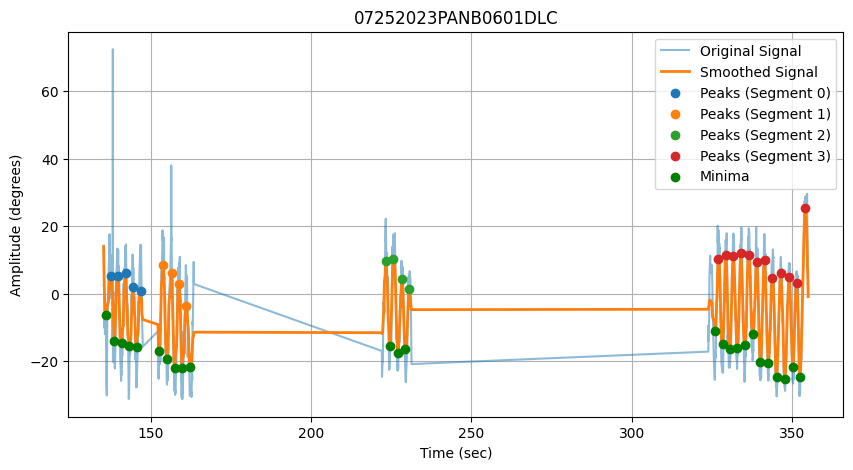

transf_07252023PANB0704DLC.csv


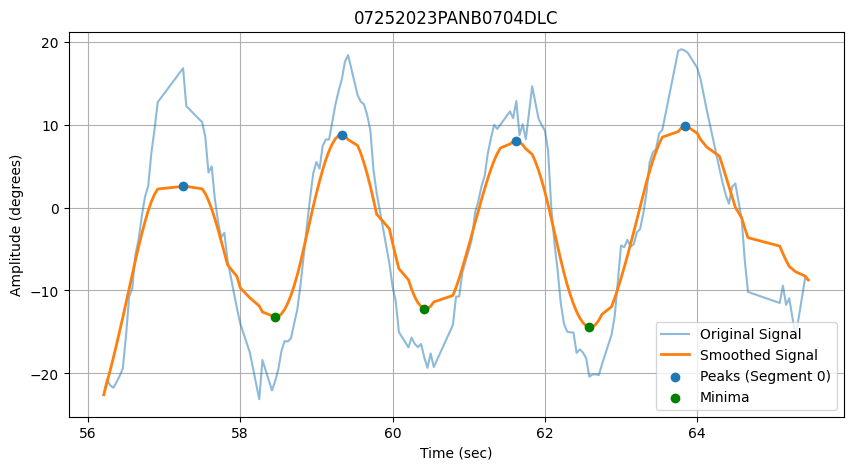

transf_07252023PANB0605DLC.csv


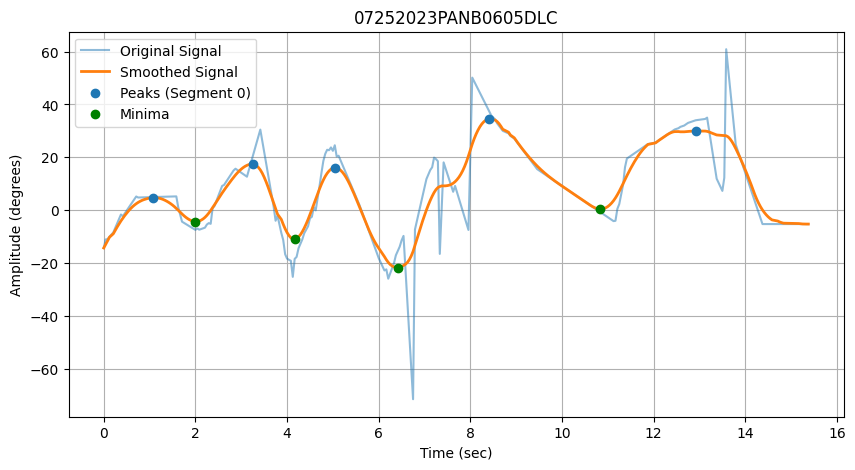

transf_07252023PANB0708DLC.csv


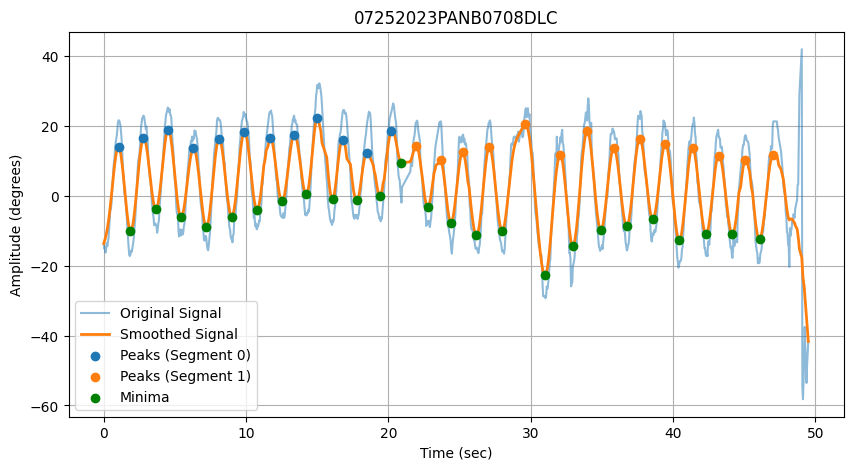

transf_07252023PANB0701DLC.csv


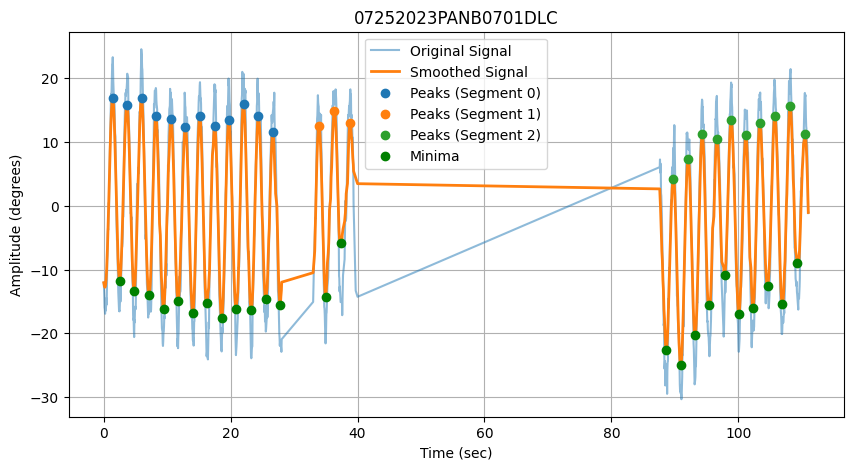

transf_07252023PANB0705DLC.csv


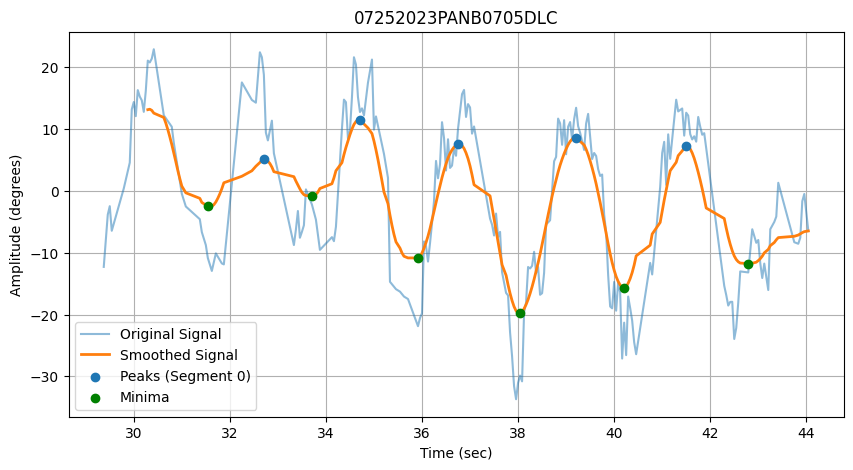

transf_07252023PANB0702DLC.csv


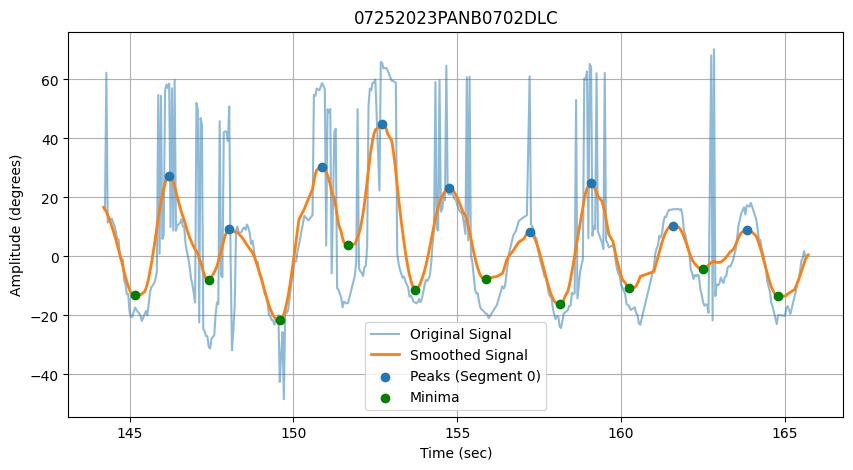

transf_07252023PANB0709DLC.csv


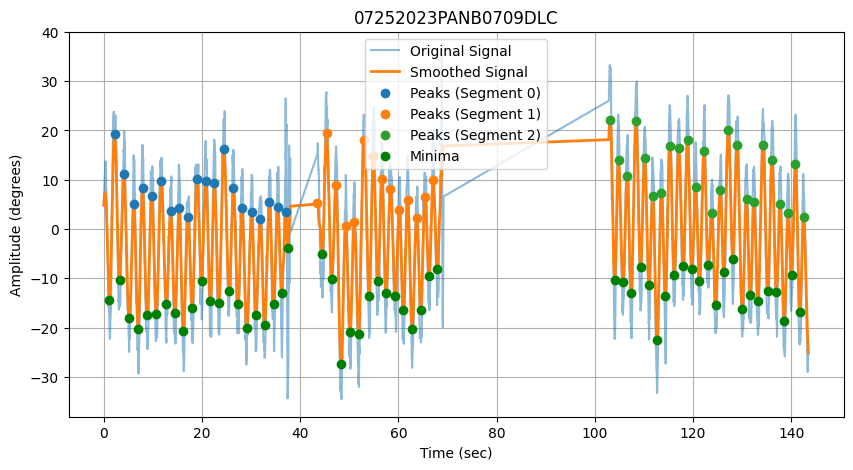

transf_07272023PANB0102DLC.csv


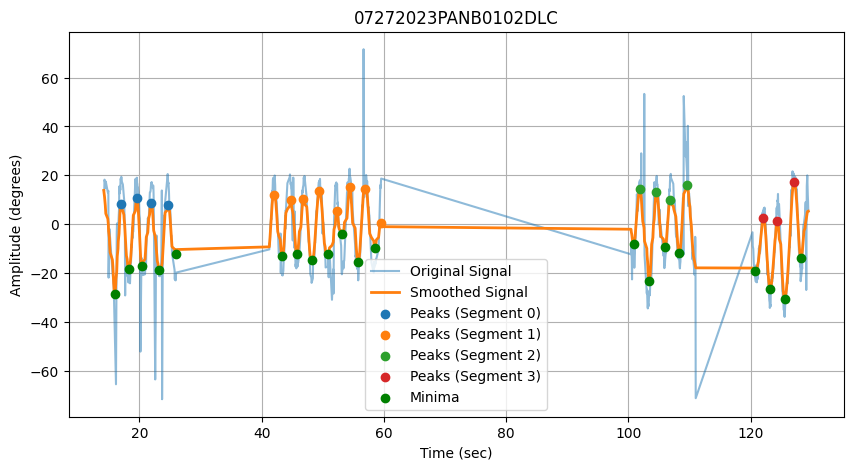

transf_07272023PANB0401DLC.csv


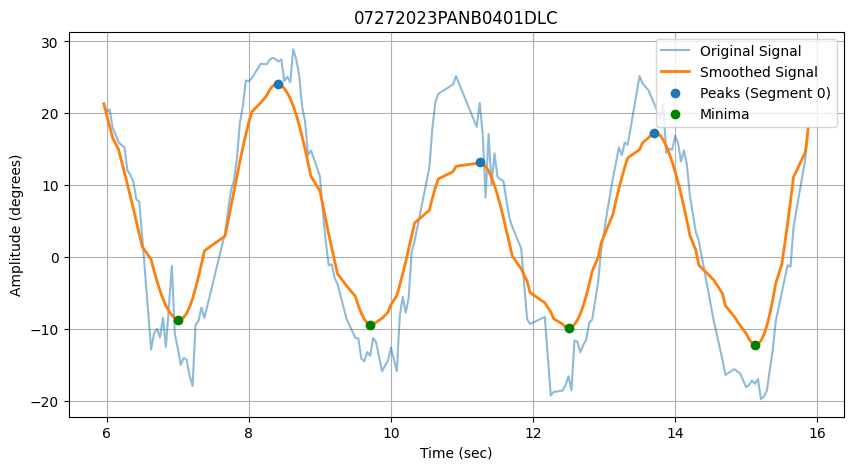

transf_07272023PANB0502DLC.csv


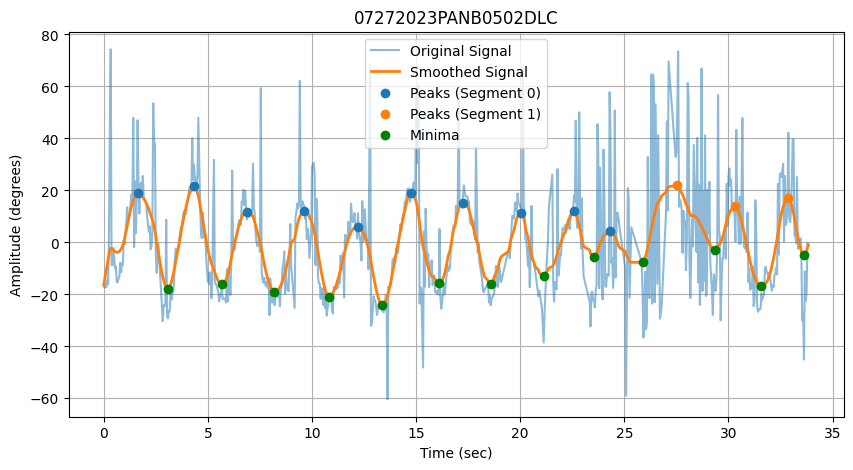

transf_07272023PANB0504DLC.csv


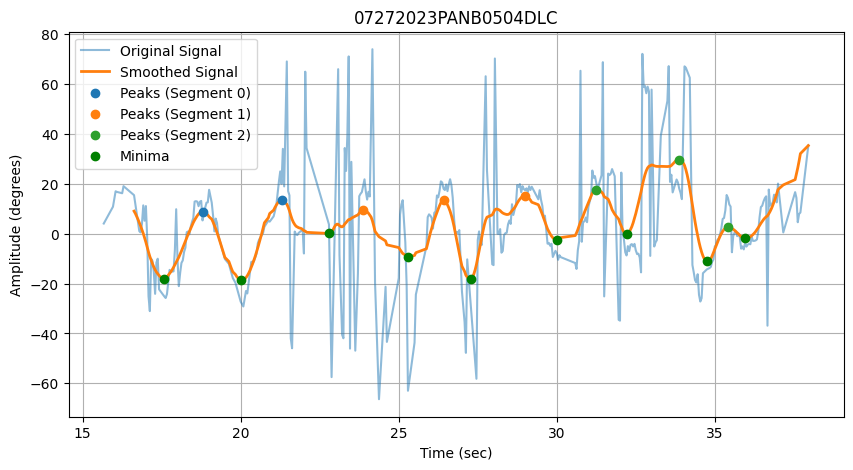

transf_07272023PANB0602DLC.csv


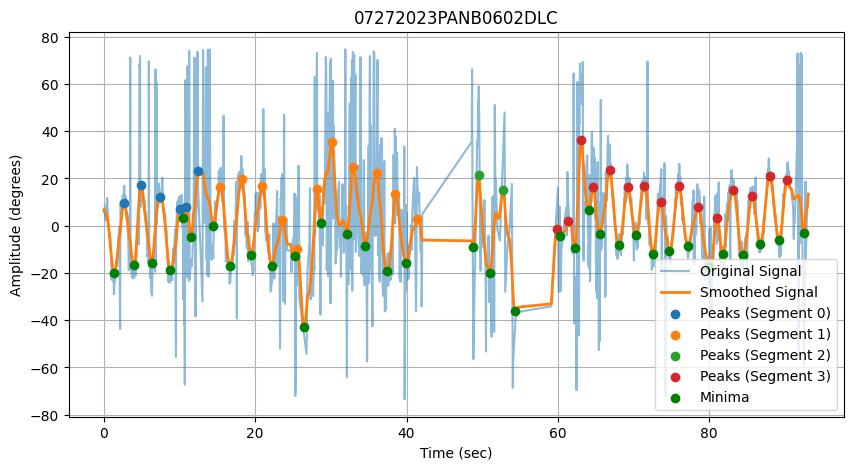

transf_07272023PANB0503DLC.csv


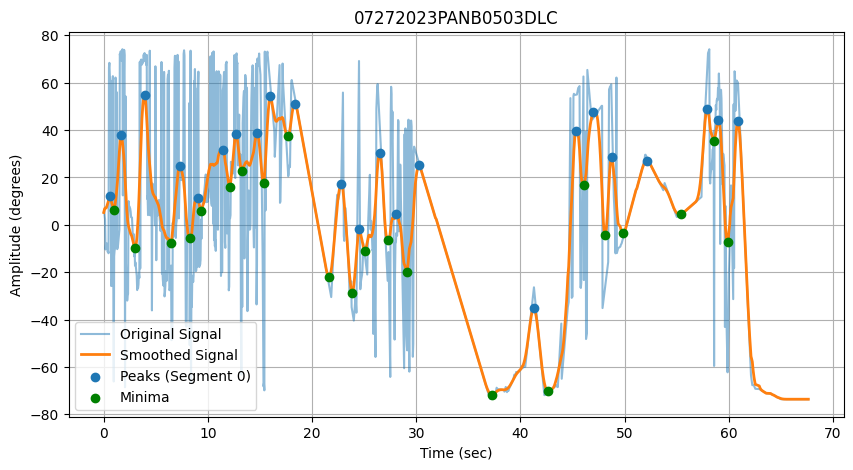

transf_07272023PANB0501DLC.csv


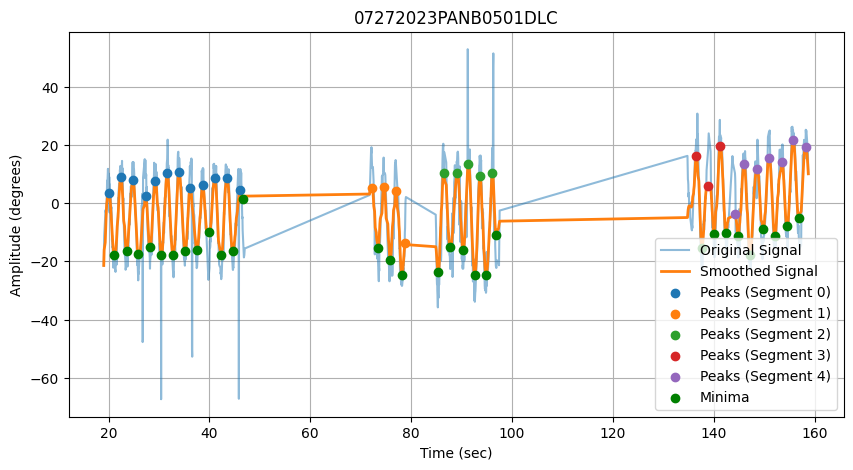

transf_07272023PANB0703DLC.csv


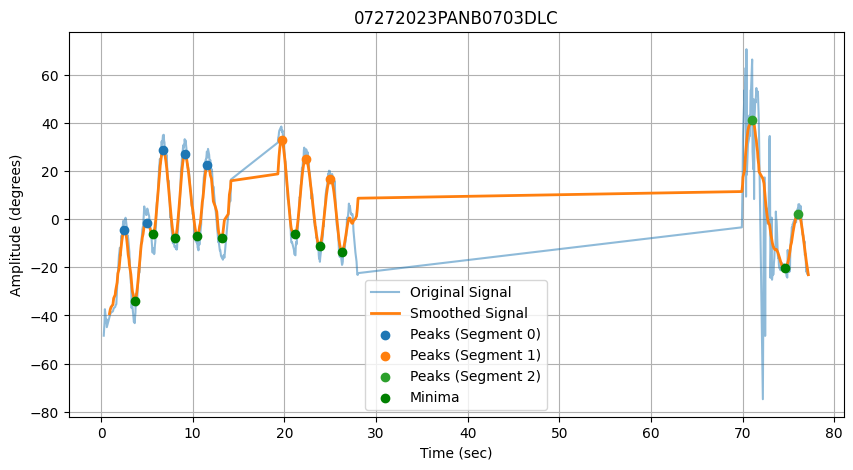

transf_07272023PANB0604DLC.csv


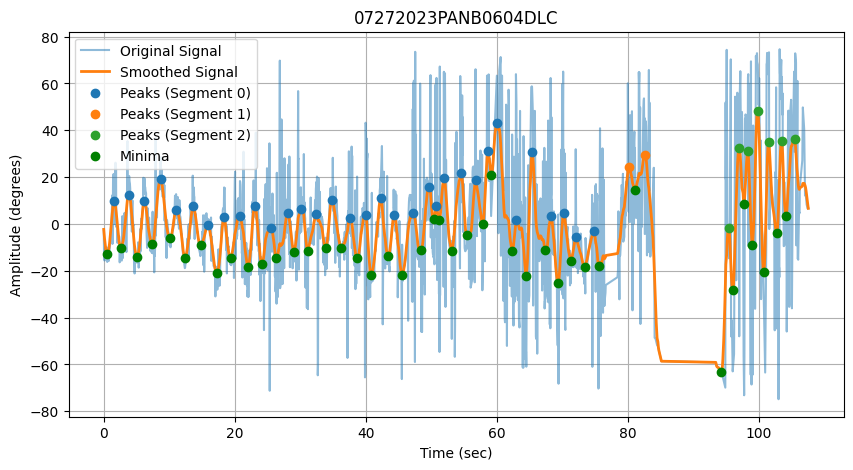

transf_07272023PANB0801DLC.csv


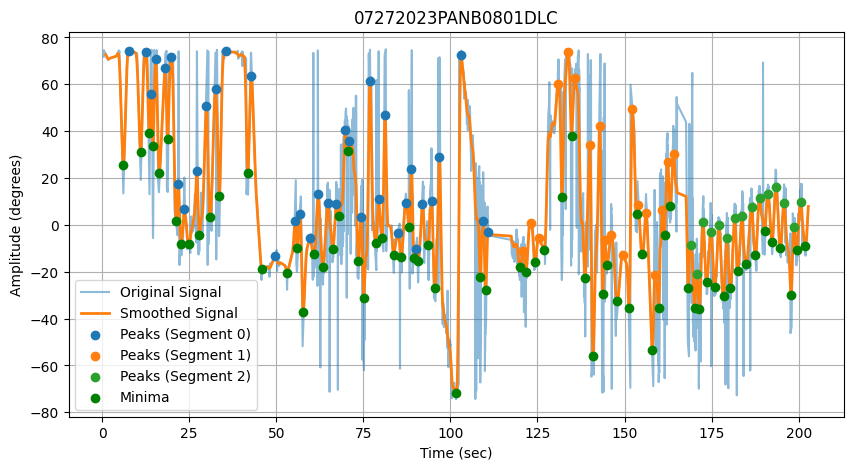

transf_07272023PANB0803DLC.csv


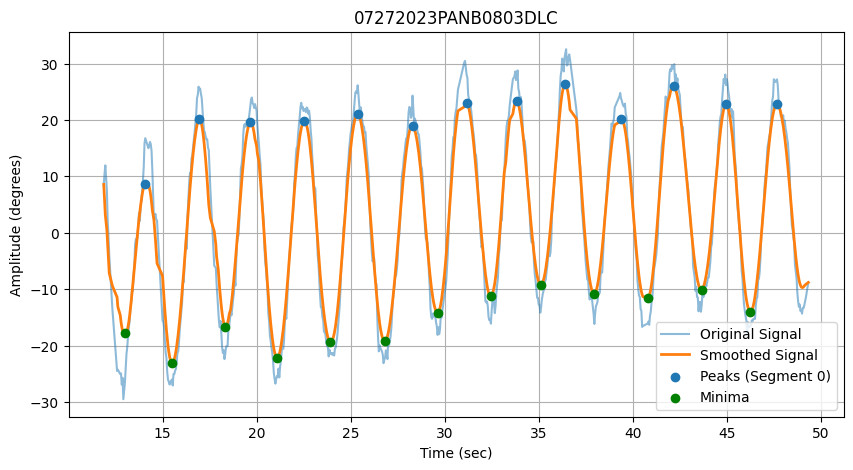

transf_07272023PANB0702DLC.csv


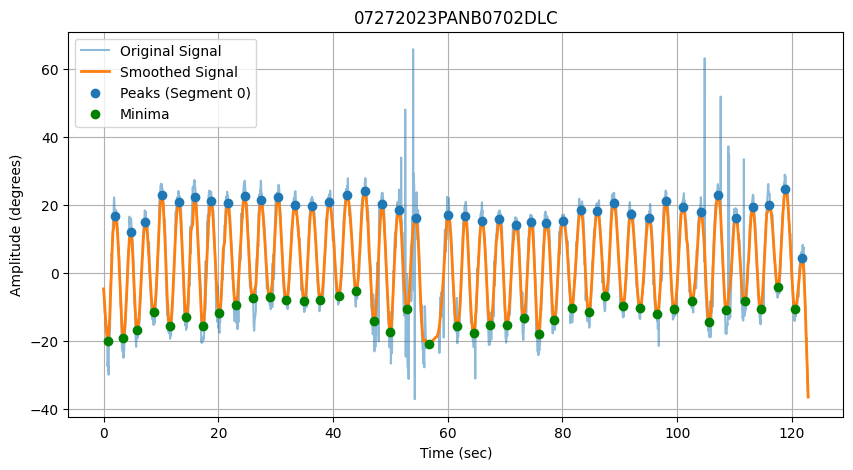

transf_07272023PANB0804DLC.csv


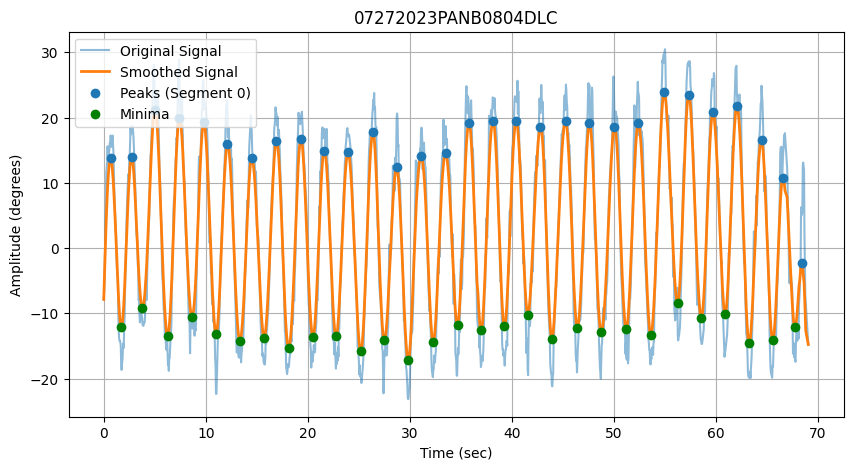

transf_07272023PANB0805DLC.csv


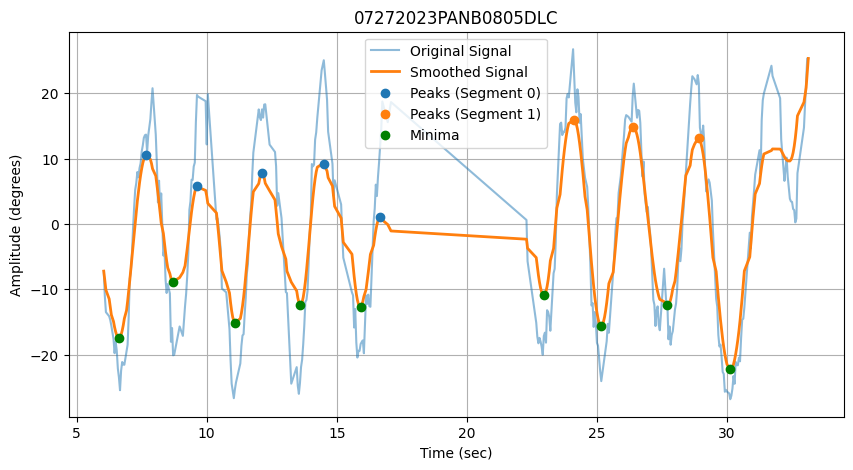

transf_08112022PANB0102DLC.csv


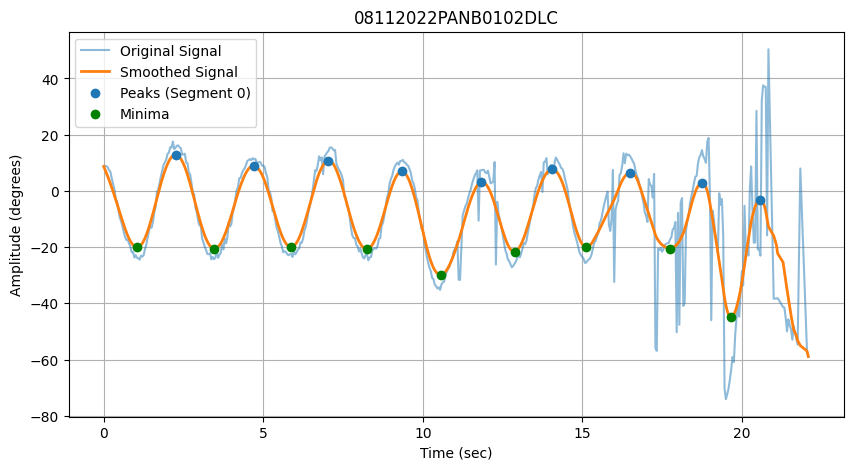

transf_07222022PANB0202DLC.csv


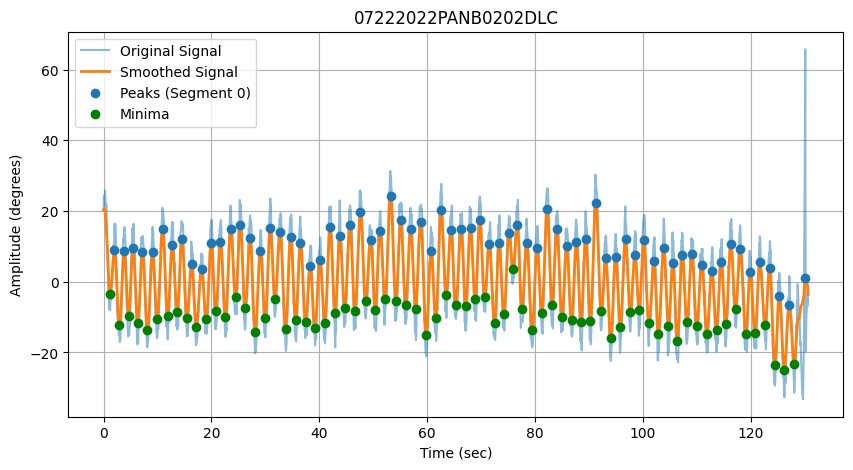

transf_08112022PANB0101 (2)DLC.csv


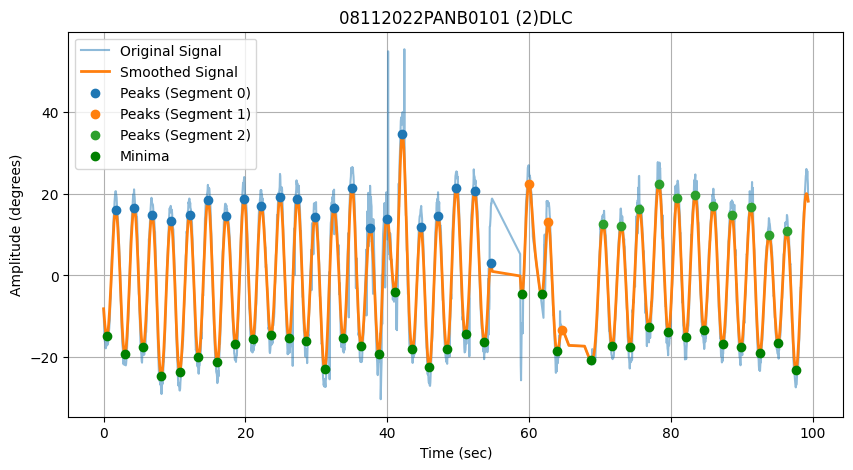

transf_08112022PANB0103DLC.csv


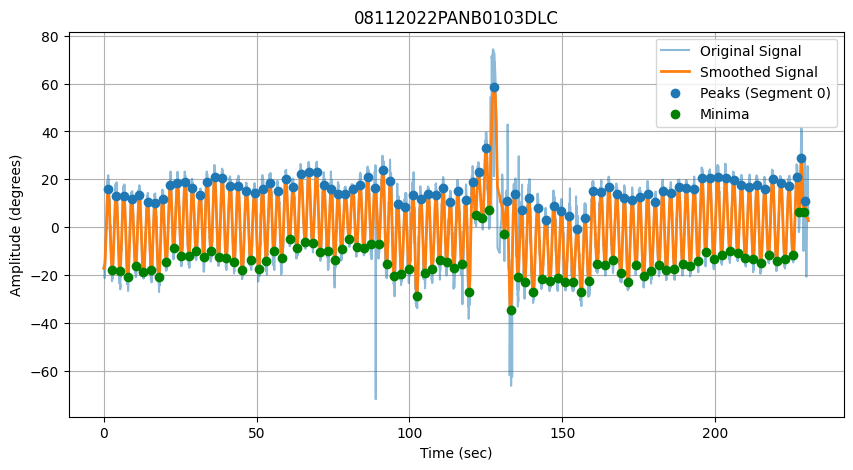

transf_08112022PANB0202DLC.csv


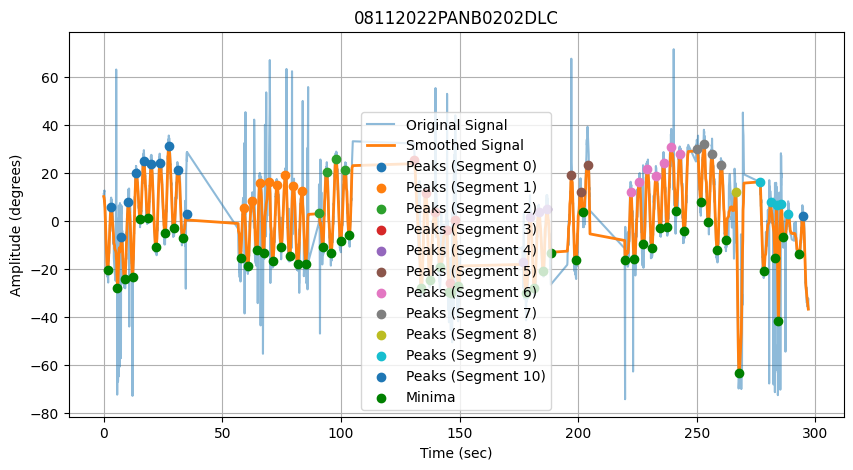

transf_08112022PANB0203DLC.csv


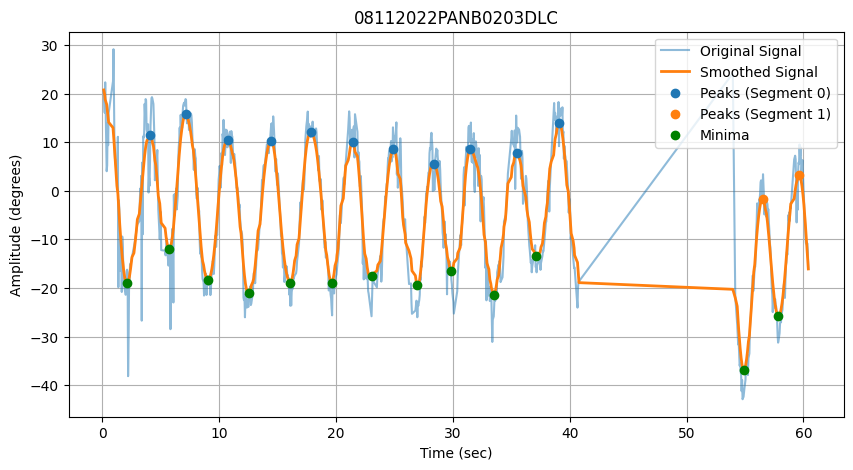

transf_08112022PANB0402DLC.csv


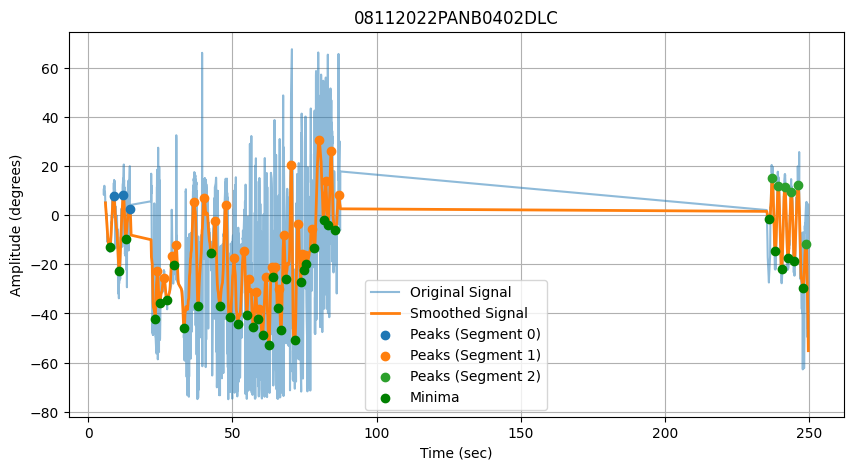

transf_08112022PANB0502DLC.csv


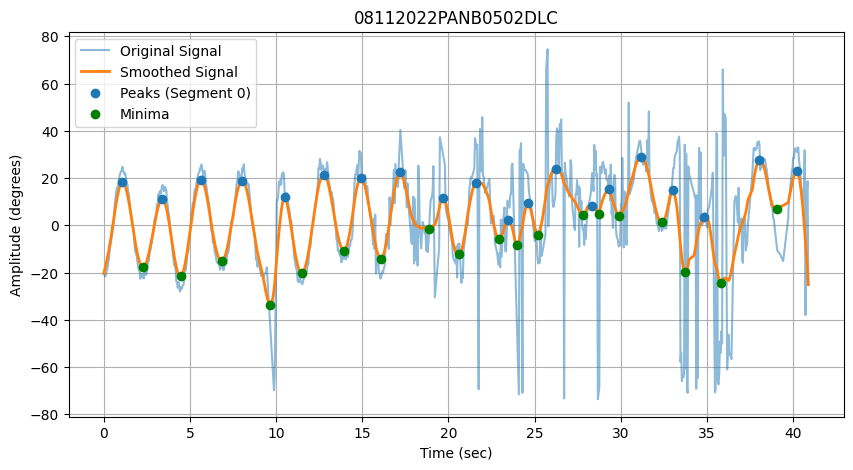

transf_08112022PANB0501DLC.csv


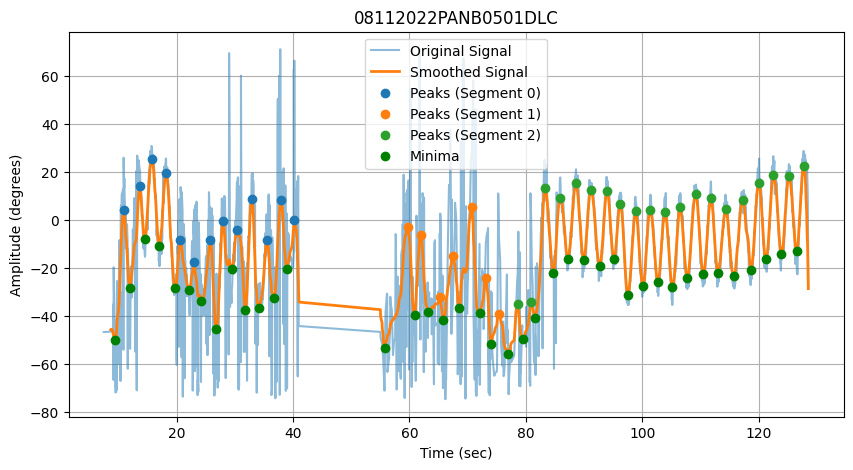

transf_08112022PANB0403DLC.csv


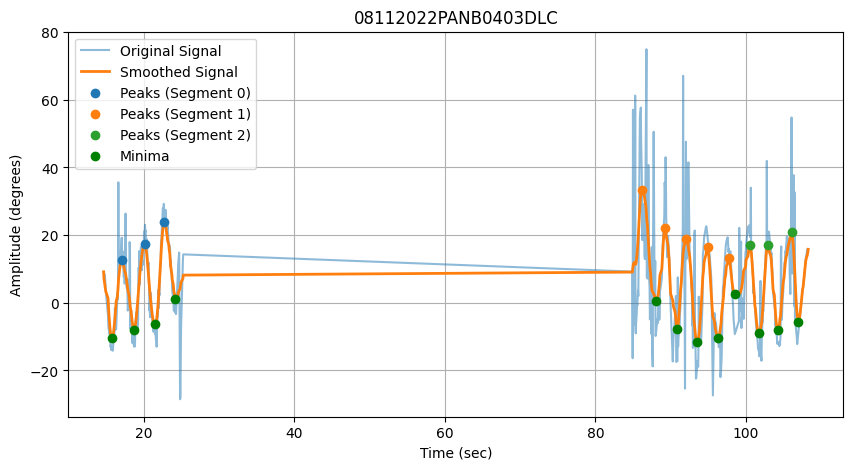

transf_08112022PANB0505DLC.csv


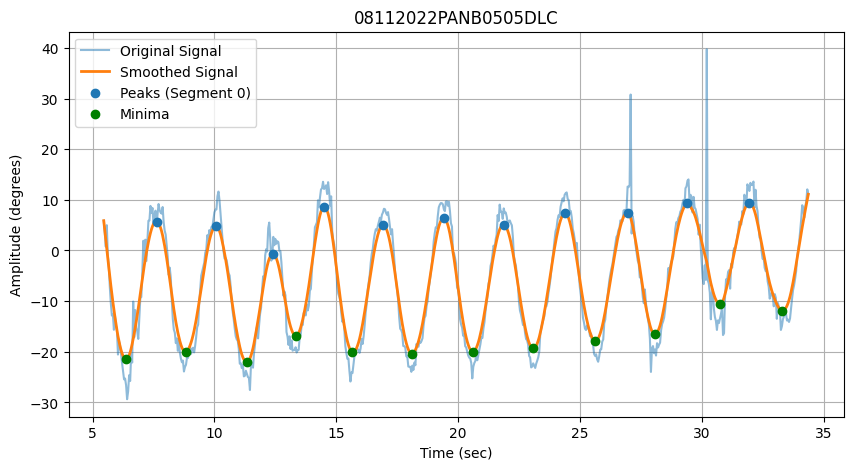

transf_08112022PANB0504DLC.csv


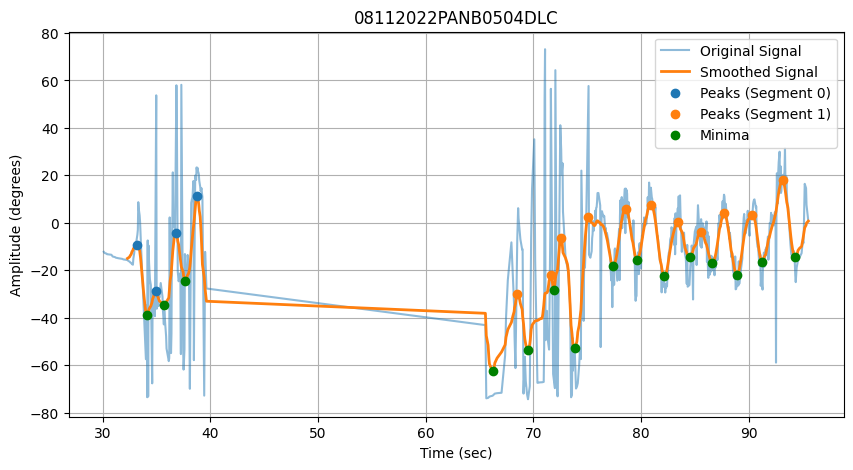

transf_08112022PANB0602DLC.csv


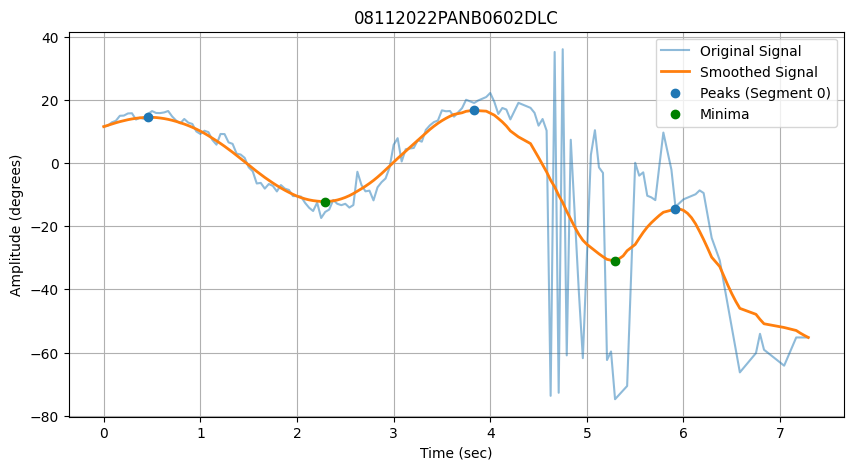

transf_08112022PANB0503DLC.csv


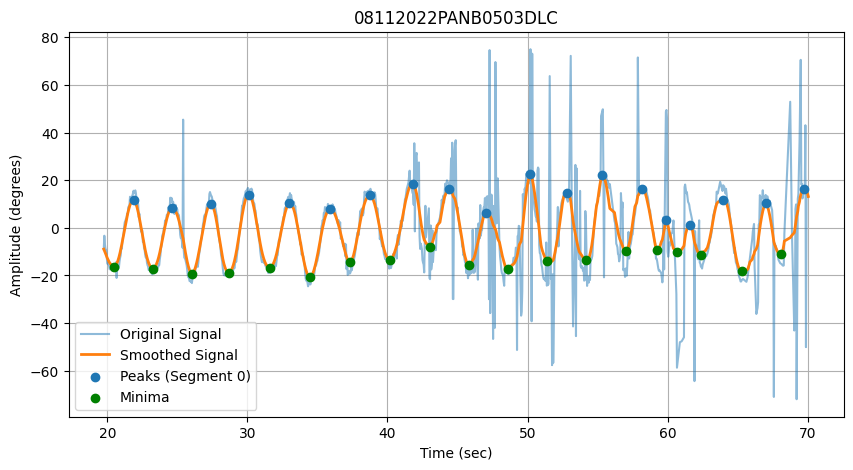

transf_08112022PANB0604DLC.csv


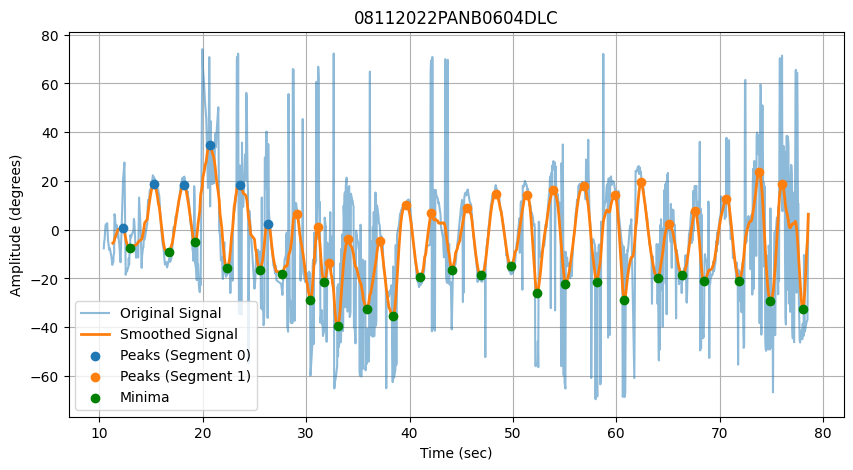

transf_08112022PANB0401DLC.csv


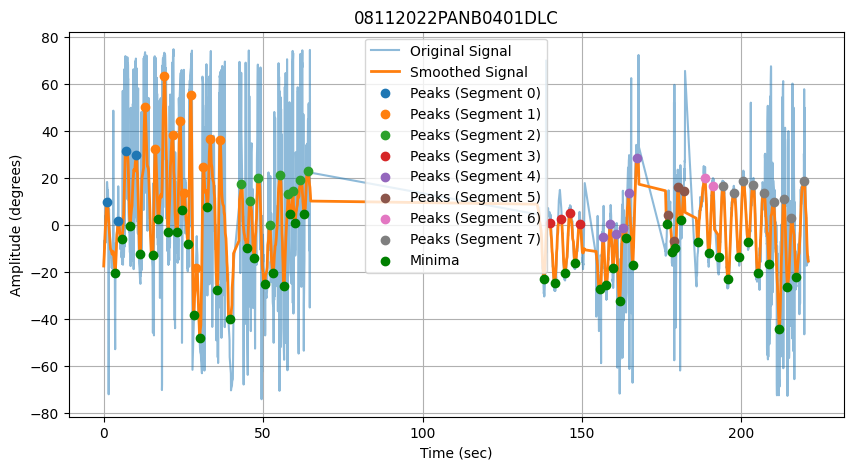

transf_08222022PANB0203DLC.csv


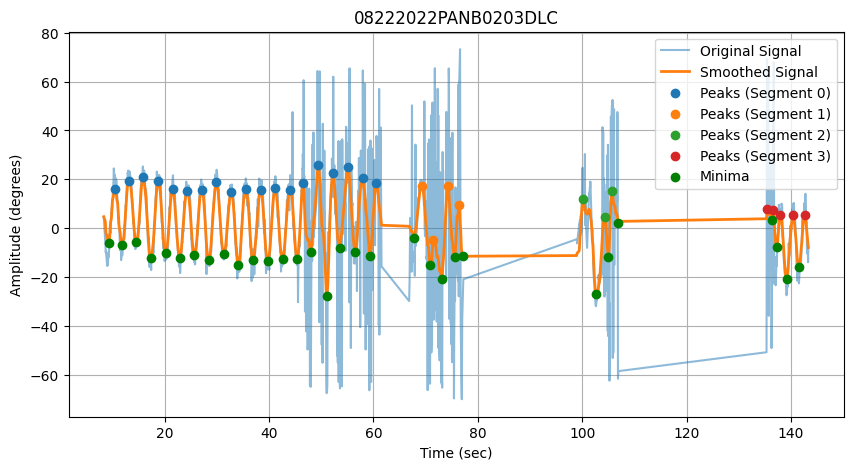

transf_08222022PANB0201DLC.csv


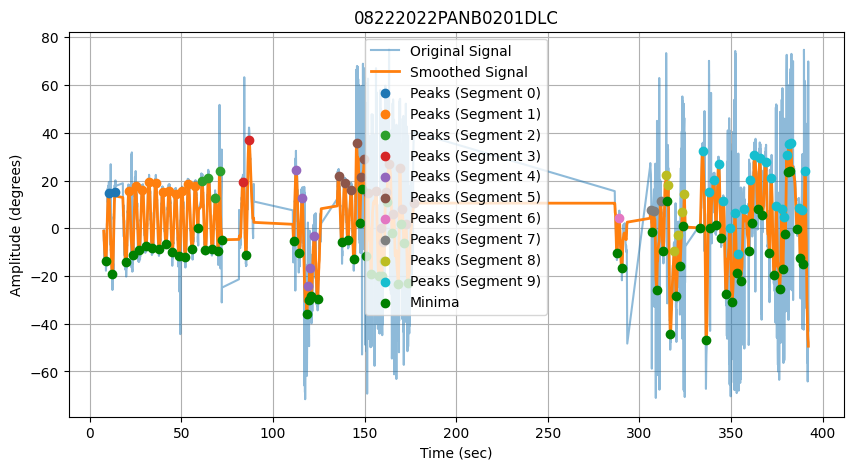

transf_08112022PANB0605DLC.csv


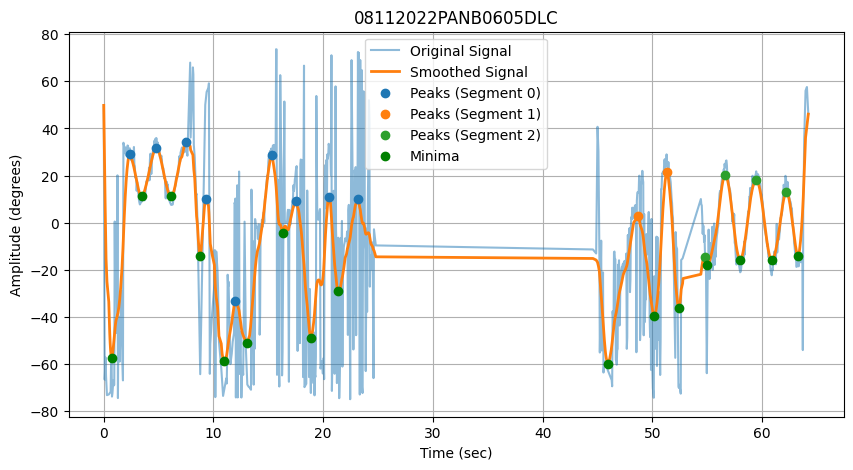

transf_08222022PANB0301DLC.csv


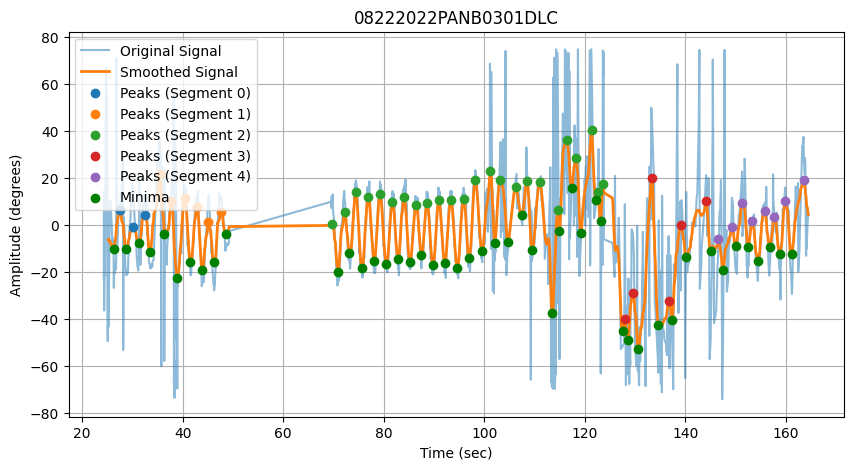

transf_08222022PANB0702DLC.csv


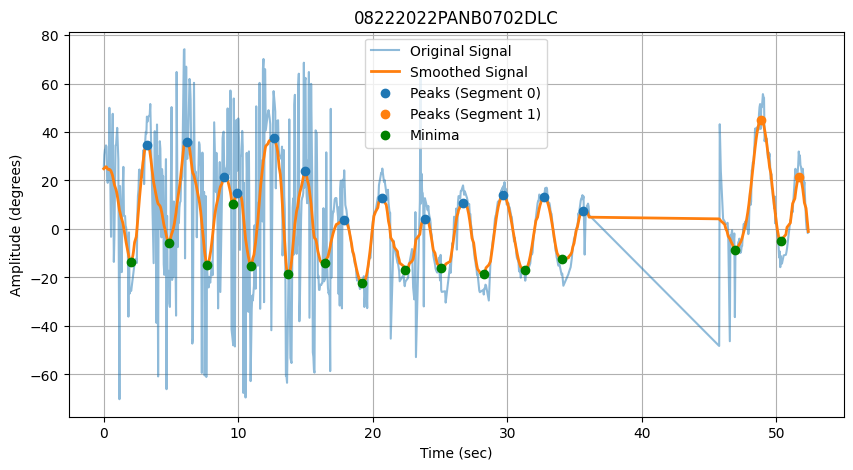

transf_08222022PANB0303DLC.csv


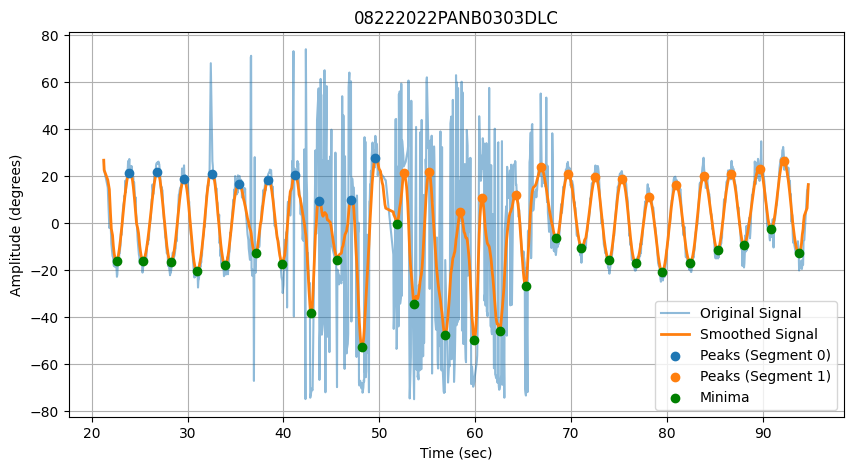

transf_08302022PANB0202DLC.csv


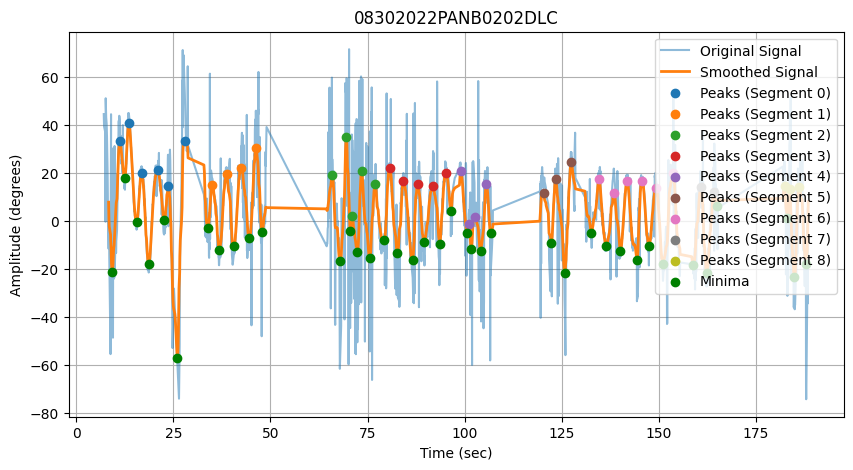

transf_08112022PANB0201DLC.csv


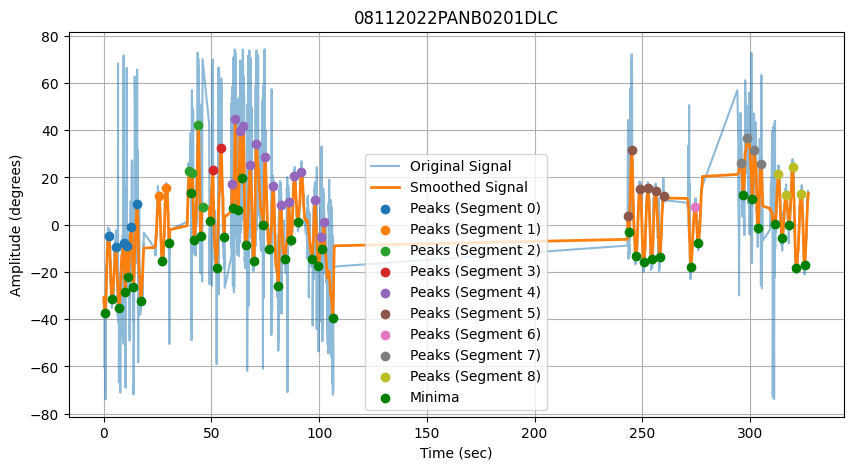

In [99]:
# loops through and reads in files in folder of cleaned files from Tail_Position_Series_Constructor.ipynb
folder_path = "I:/documents/DLCPaper/revisions/data/kinematic/coordinates_transformed/all"
exportfolder_path = "I:/documents/DLCPaper/revisions/data/kinematic/cycles/all"

# get a list of all the files in the folder
file_list = os.listdir(folder_path)

# loop through CSV files
for file_name in file_list: 
    if file_name.endswith(".csv") and not file_name.startswith("._"):
        print(file_name)
        file_path = os.path.join(folder_path, file_name)
        export_path = os.path.join(exportfolder_path, 'cycles_' + file_name.split('_')[1])

        try:
            df = pd.read_csv(file_path, encoding='utf-8')

            # call the extract_cycles function to process the df
            kinematics_df = extract_tailangle_cycles(df,minimum_signal=15)
            
            # check if resultant df is empty
            if kinematics_df.empty:
                print(f"Warning: No nose cycles found in {file_name}. Skipping.")
                continue 

            kinematics_df['filename'] = file_name.split('_')[1]
            kinematics_df.to_csv(export_path, index=False)
        
            # export the plot
            plot_filename = f"flexangle_plot_{file_name.split('_')[1]}.png"
            
            plot_tailangle(df)
            plt.close()  
            
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            continue  # skip to the next file on error

####